In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

Using TensorFlow backend.


# Data Download

In [2]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [13]:
!conda install -c anaconda wget --yes


Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - wget


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.4                |           py37_0         3.0 MB  anaconda
    wget-1.20.1                |       h051b688_0         478 KB  anaconda
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following NEW packages will be INSTALLED:

  wget               anaconda/osx-64::wget-1.20.1-h051b688_0

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.8.4-py37hc8dfbb8~ --> anaconda::conda-4.8.4-py37_0



conda-4.8.4          | 3.0 MB    | ##################################### | 100% 
wget-1.20.1          | 478 KB    | ##################################### | 100% 
Preparing 

In [14]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2020-08-27 20:34:37--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org... 128.101.65.152
Connecting to files.grouplens.org|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: 'ml-100k.zip'

ml-100k.zip         100%[===================>]   4.70M  2.28MB/s    in 2.1s    

2020-08-27 20:34:40 (2.28 MB/s) - 'ml-100k.zip' saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test      

Here we read two files for user and movies and finally merge them together

In [15]:
col1 = ['user_id', 'movie_id', 'rating', 'timestamp']
col2  = ['movie_id','movie_title']
data1 = pd.read_csv("ml-100k/u.data",sep='\t',header=None,names=col1)
data1.head()


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
data2=pd.read_csv("ml-100k/u.item",sep='|',header=None,encoding='latin-1',usecols=[0, 1],names=col2)
data2.head()

,movie_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


## Data Exploration



In [17]:
data=pd.merge(data1,data2,on='movie_id')
data.head()

,user_id,movie_id,rating,timestamp,movie_title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


Here we calculate the mean rating of all movies and displaying top 5 movies with highest average rating

In [18]:

rat=data.groupby('movie_title')['rating'].mean().sort_values(ascending=False)
rat.head()

movie_title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

Here we display the top 50 movies with the highest number of ratings given by user

In [20]:
top_50 = data.groupby('movie_title').size().sort_values(ascending=False)[:50]
top_50["Total Ratings"] = data.groupby('movie_title').size()
print(top_50)

movie_title
Star Wars (1977)                                                                              583
Contact (1997)                                                                                509
Fargo (1996)                                                                                  508
Return of the Jedi (1983)                                                                     507
Liar Liar (1997)                                                                              485
English Patient, The (1996)                                                                   481
Scream (1996)                                                                                 478
Toy Story (1995)                                                                              452
Air Force One (1997)                                                                          431
Independence Day (ID4) (1996)                                                                 429
Raiders 

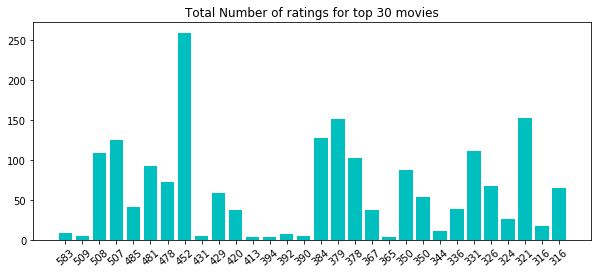

In [21]:
plt.figure(figsize =(10, 4))
ax=plt.subplot()
ax.bar(top_50.head(30).index,top_50["Total Ratings"].head(30),color='c')
ax.set_xticklabels(top_50,rotation=40)
ax.set_title("Total Number of ratings for top 30 movies")
plt.show()

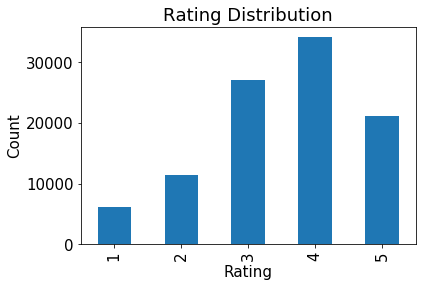

In [22]:
plt.rc("font", size=15)
data1.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Since we now know the highest rated movies and we know the number of rating for each user, we can come up with a threshold for the movies which shpuld be recommended for new users as collaborative filtering cant be applied to the new user since we have no information on the user preference, so we choose movies which surpasses the threhold of 250 for number of ratings and  the avergae rating more than 4 and recommend it to new user

In [23]:
ratn=data.groupby('movie_title')['rating'].mean()

num_rat=data.groupby('movie_title').size()
movie=[]
for i in range(0,len(ratn)):
  if ratn[i]>4 and num_rat[i]>300:
    movie.append(ratn.index[i])
print("Movies Recommended for a new user:")
movie

Movies Recommended for a new user:


['Empire Strikes Back, The (1980)',
 'Fargo (1996)',
 'Fugitive, The (1993)',
 'Godfather, The (1972)',
 'Monty Python and the Holy Grail (1974)',
 'Princess Bride, The (1987)',
 'Pulp Fiction (1994)',
 'Raiders of the Lost Ark (1981)',
 'Return of the Jedi (1983)',
 'Silence of the Lambs, The (1991)',
 'Star Wars (1977)',
 'Titanic (1997)']

In [24]:
data=data.drop_duplicates(['user_id', 'movie_title'])
pivot_data = data.pivot(
    index='user_id',
    columns='movie_title',
    values='rating'
).fillna(0)
pivot_data.head()


movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


<h1>KNN</h1>

In [47]:
m_movie = csr_matrix(pivot_data.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(m_movie)
print(pivot_data.shape)

(943, 1664)


Applying KNN method to find similar users

In [48]:
def similar_user(user):
    distances, indices = model_knn.kneighbors(pivot_data.iloc[user, :].values.reshape(1, -1), n_neighbors = 6)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Similar User for {0}:\n'.format(pivot_data.index[user-1]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, pivot_data.index[indices.flatten()[i]], distances.flatten()[i]))
    return indices.flatten()


Here we pass a user_id to the function and top 5 similar users are displayed

In [49]:
indices=similar_user(777)
indices=indices[1:]

Similar User for 777:

1: 124, with distance of 0.4586649429539592:
2: 933, with distance of 0.5581959868865324:
3: 56, with distance of 0.5858413112292744:
4: 738, with distance of 0.5916272517988691:
5: 653, with distance of 0.5991479757406326:


In [50]:
similar_data=pivot_data.iloc[indices-1, :]


In [51]:
rat_list=[]
for i in range(0, similar_data.shape[1]):
    arr=np.asarray(similar_data.iloc[:,i])
    rat_list.append(np.mean(arr))
    
rat_list=np.asarray(rat_list)   

In [52]:
t = np.argpartition(-rat_list, 10)
result_ind = t[:10]

temp = np.partition(-rat_list, 10)
result = -temp[:10]

After finding similar user using KNN method by cosine similarity, we predict the rating of the movies by the user based on average ratings for the movies by similar users and recommend the highest rated movie.

In [53]:
x = np.asarray(similar_data.columns)
print("Recomemndation for the input user:")
x[result_ind]

Recomemndation for the input user:


array(['Braveheart (1995)', 'Godfather, The (1972)',
       'Blade Runner (1982)',
       'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
       'Graduate, The (1967)', 'To Kill a Mockingbird (1962)',
       'Fargo (1996)', 'Dead Man Walking (1995)',
       'Terminator 2: Judgment Day (1991)', 'Lawrence of Arabia (1962)'],
      dtype=object)